# Task 2

## 1. Experimental design

This dataset examines physiological and emotional responses during competitive puzzle-solving tasks:

* Participants: 
   * 26 participants (ages 20-42) organised into three cohorts:
       * Cohort 1 (D11): 8 participants (collected in winter)
       * Cohort 2 (D12): 6 participants (collected in fall)
       * Cohort 3 (D13): 14 participants (collected in fall, further divided into D13-D16)
   * Participants worked in teams of two with distinct roles:
       * Puzzle-solver: The only person allowed to physically manipulate puzzle pieces
       * Instructor: The only person allowed to view puzzle solutions

* Structure:
   * 4 successive rounds per participant
   * Each round consisted of:
       * Calibration period (1 minute)
       * Phase 1: Pre-puzzle resting (5 minutes)
       * Phase 2: Tangram puzzle-solving task (5 minutes)
       * Phase 3: Post-puzzle recovery (5 minutes)
       * Self-rated questionnaires (60 seconds reserved at the end of pre-task and task phases)
   * Total duration per round: 19 minutes

* Measurements:
   * Continuous physiological data via Empatica E4 wristband:
       * Heart rate (HR)
       * Temperature (TEMP)
       * Electrodermal Activity (EDA)
       * Blood-volume pulse (BVP)
   * Self-rated questionnaires using I-PANAS-SF after each phase:
       * Five positive emotions (active, alert, attentive, determined, inspired)
       * Five negative emotions (afraid, ashamed, hostile, nervous, upset)
       * Frustration level (scale 0-10)
       * Task difficulty rating (scale 0-10, puzzle phase only)

The experiment was designed as a game-elicited-emotion paradigm to induce stress and frustration during competitive team interactions. This allows for analysis of physiological and emotional responses under social pressure and competitive conditions.

## 2. Initial data processing

1. **Reshaping**: Changed data from long format (312 rows) to wide format (26 rows), making analysis simpler.

2. **Naming system**: Created clear prefixes like `Base_` for baseline measurements and patterns like `P2R1_` for experimental phases.

3. **Emotion scores**: Combined individual emotion ratings into Positive Affect (PA) and Negative Affect (NA) summary scores.

4. **Standardisation**: Added standardised values for physiological measurements to account for individual differences.

5. **Variable selection**: Removed redundant statistics, reducing from 68 to 44 variables while keeping essential information.

## 3. Further data processing

1. **Baseline changes**: Calculated differences between competition measures and participant baselines to account for natural variations.

2. **Round comparisons**: Examined changes between consecutive rounds to identify stress patterns or adaptation over time.

3. **Variability adjustment**: Converted measurements to z-scores based on individual response patterns for fair comparisons.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Configure plot styling
plt.style.use("classic")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.facecolor": "white",
    "font.family": "serif",
    "figure.dpi": 200,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
})

In [2]:
def process_physiological_data(df):
    """Process physiological data by calculating deltas and z-scores"""
    measures = {
        'EDA_P': {'base': 'Base_EDA_TD_P_AUC', 'std': 'std_EDA_P', 
                 'rounds': ['P2R1_EDA_TD_P_AUC', 'P2R2_EDA_TD_P_AUC', 'P2R3_EDA_TD_P_AUC', 'P2R4_EDA_TD_P_AUC']},
        'EDA_T': {'base': 'Base_EDA_TD_T_AUC', 'std': 'std_EDA_T',
                 'rounds': ['P2R1_EDA_TD_T_AUC', 'P2R2_EDA_TD_T_AUC', 'P2R3_EDA_TD_T_AUC', 'P2R4_EDA_TD_T_AUC']},
        'HR': {'base': 'Base_HR_TD_Median', 'std': 'std_HR',
              'rounds': ['P2R1_HR_TD_Median', 'P2R2_HR_TD_Median', 'P2R3_HR_TD_Median', 'P2R4_HR_TD_Median']},
        'TEMP': {'base': 'Base_TEMP_TD_Mean', 'std': ' std_TEMP',  # Note the leading space in column name
                'rounds': ['P2R1_TEMP_TD_Mean', 'P2R2_TEMP_TD_Mean', 'P2R3_TEMP_TD_Mean', 'P2R4_TEMP_TD_Mean']},
        'PA': {'base': 'Base_PA', 'std': None,
              'rounds': ['P2R1_PA', 'P2R2_PA', 'P2R3_PA', 'P2R4_PA']},
        'NA': {'base': 'Base_NA', 'std': None,
              'rounds': ['P2R1_NA', 'P2R2_NA', 'P2R3_NA', 'P2R4_NA']}
    }

    # Calculate missing standard deviations
    for measure, info in measures.items():
        if info['std'] is None:
            std_col = f"computed_std_{measure}"
            std_value = df[info['base']].std()
            df[std_col] = std_value
            measures[measure]['std'] = std_col

    # Calculate baseline deltas (P2Rx - Base)
    for measure, info in measures.items():
        for round_col in info['rounds']:
            delta_col = f"d_{round_col}"
            df[delta_col] = df[round_col] - df[info['base']]

    # Calculate round-to-round deltas (P2Rx - P2Rx-1)
    for measure, info in measures.items():
        for i in range(1, len(info['rounds'])):
            delta_col = f"d_{info['rounds'][i]}_vs_{info['rounds'][i-1]}"
            df[delta_col] = df[info['rounds'][i]] - df[info['rounds'][i-1]]

    # Calculate Z-scores for baseline deltas
    for measure, info in measures.items():
        for round_col in info['rounds']:
            delta_col = f"d_{round_col}"
            z_col = f"z_{delta_col}"
            df[z_col] = df[delta_col] / df[info['std']]
            
    # Calculate Z-scores for round-to-round deltas
    for measure, info in measures.items():
        for i in range(1, len(info['rounds'])):
            delta_col = f"d_{info['rounds'][i]}_vs_{info['rounds'][i-1]}"
            z_col = f"z_{delta_col}"
            # Using population standard deviation for consistency
            pop_std = df[delta_col].std()
            df[z_col] = df[delta_col] / pop_std

    return df

# Process and save data
df = pd.read_csv('data/HR_data_dim2.csv')
processed_df = process_physiological_data(df)
processed_df.to_csv('data/HR_data_dim2_processed.csv', index=False)

## 4. Clustering

1. **Feature selection**: Selected standardised physiological and emotional measurements across all puzzle task rounds.

2. **Hierarchical clustering**: Applied Ward's method with Euclidean distance to identify natural groupings.

In [3]:
# Select features for clustering
features = [
    # Heart rate features
    'z_d_P2R1_HR_TD_Median', 'z_d_P2R2_HR_TD_Median', 'z_d_P2R3_HR_TD_Median', 'z_d_P2R4_HR_TD_Median',
    # EDA features
    'z_d_P2R1_EDA_TD_P_AUC', 'z_d_P2R2_EDA_TD_P_AUC', 'z_d_P2R3_EDA_TD_P_AUC', 'z_d_P2R4_EDA_TD_P_AUC',
    'z_d_P2R1_EDA_TD_T_AUC', 'z_d_P2R2_EDA_TD_T_AUC', 'z_d_P2R3_EDA_TD_T_AUC', 'z_d_P2R4_EDA_TD_T_AUC',
    # Temperature features
    'z_d_P2R1_TEMP_TD_Mean', 'z_d_P2R2_TEMP_TD_Mean', 'z_d_P2R3_TEMP_TD_Mean', 'z_d_P2R4_TEMP_TD_Mean',
    # Emotional features
    'z_d_P2R1_PA', 'z_d_P2R2_PA', 'z_d_P2R3_PA', 'z_d_P2R4_PA',
    'z_d_P2R1_NA', 'z_d_P2R2_NA', 'z_d_P2R3_NA', 'z_d_P2R4_NA'
]

In [4]:
# Prepare data for clustering
df_valid = df.dropna(subset=features)
X = df_valid[features].values
X_scaled = StandardScaler().fit_transform(X)  # Standardize

In [5]:
# Perform hierarchical clustering
Z = linkage(X_scaled, method='ward', metric='euclidean')

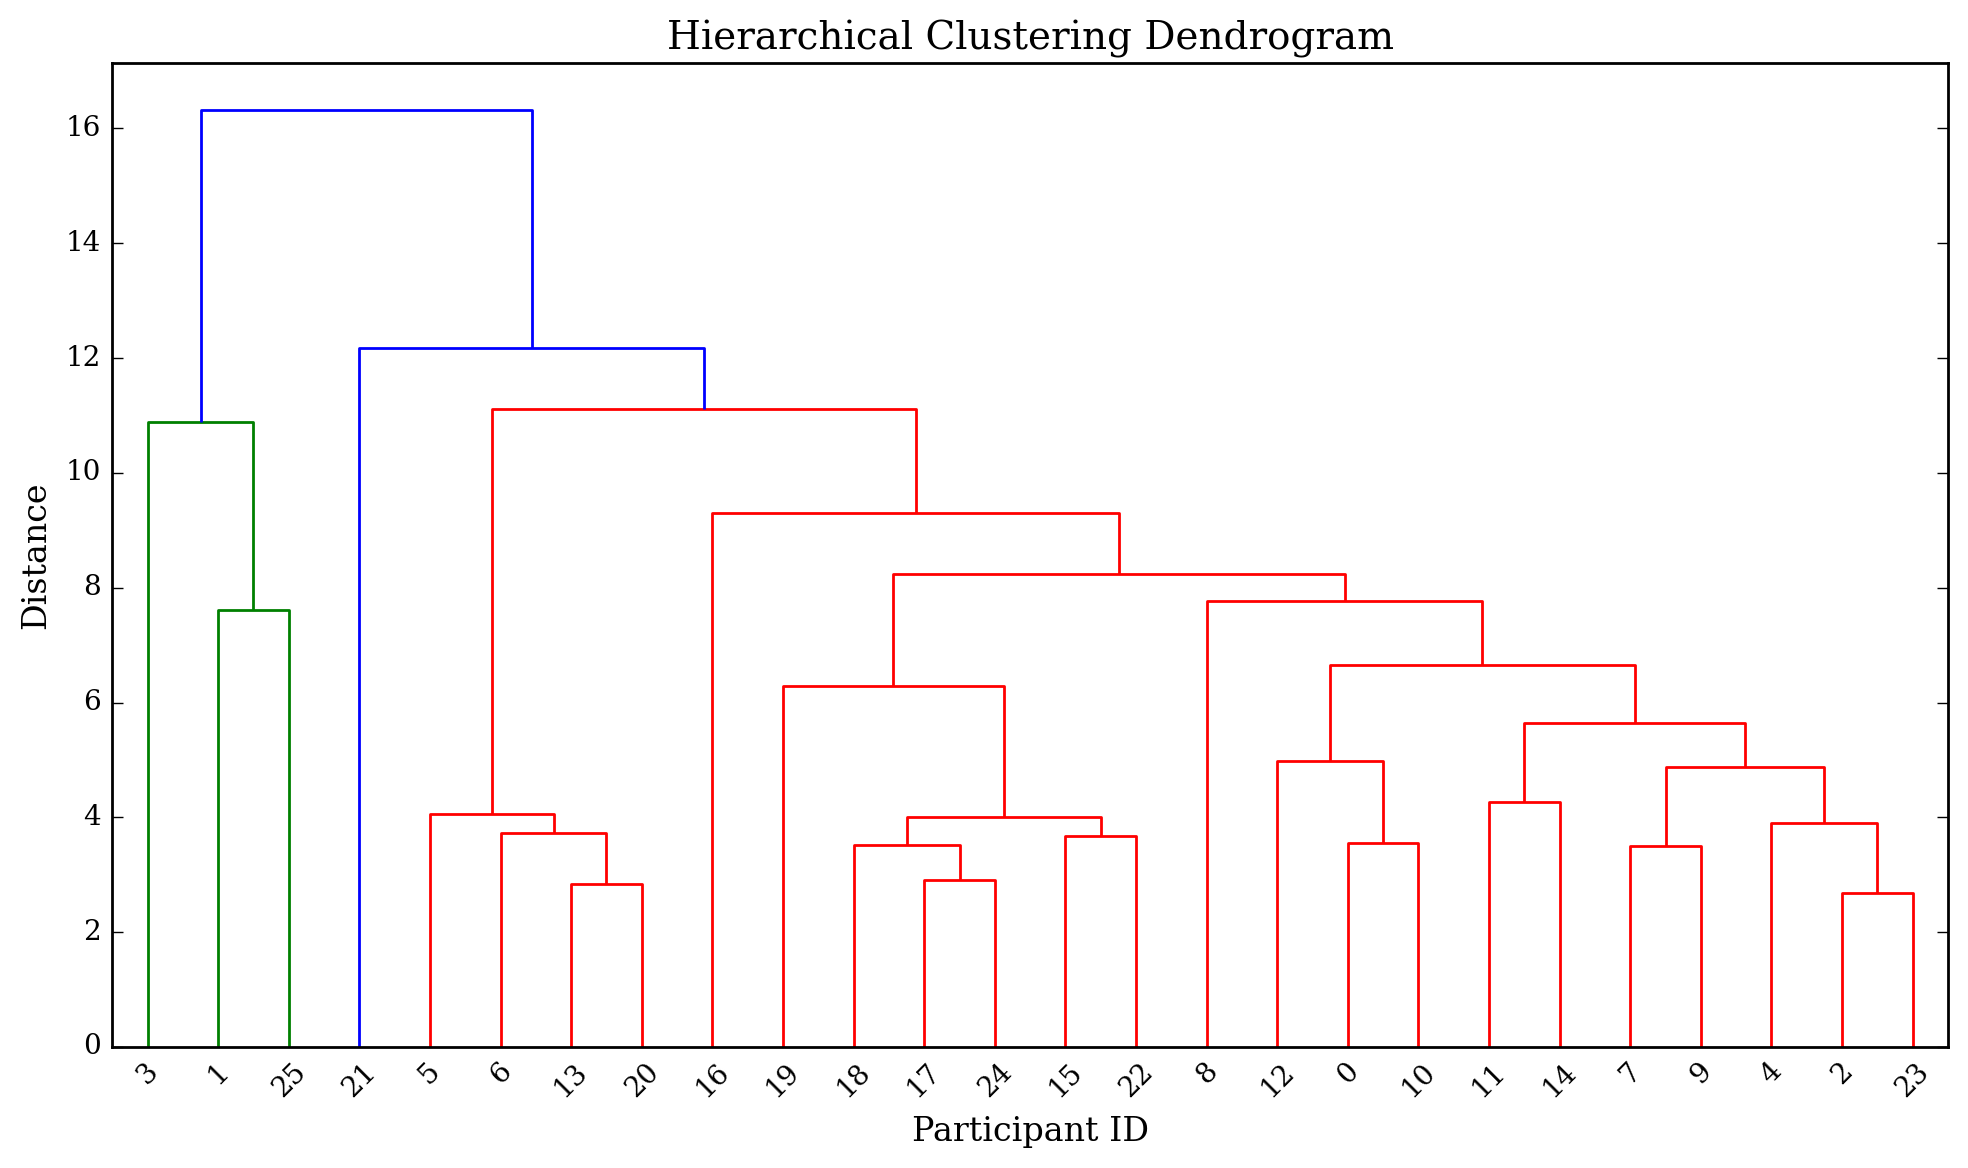

In [6]:
# Plot dendrogram
plt.figure()
dendrogram(Z, labels=df_valid.index.astype(str))
plt.xlabel('Participant ID')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()
plt.show()

3. **Optimal cluster determination**: Used silhouette scores to find the ideal number of clusters by measuring how well objects fit within their assigned cluster.

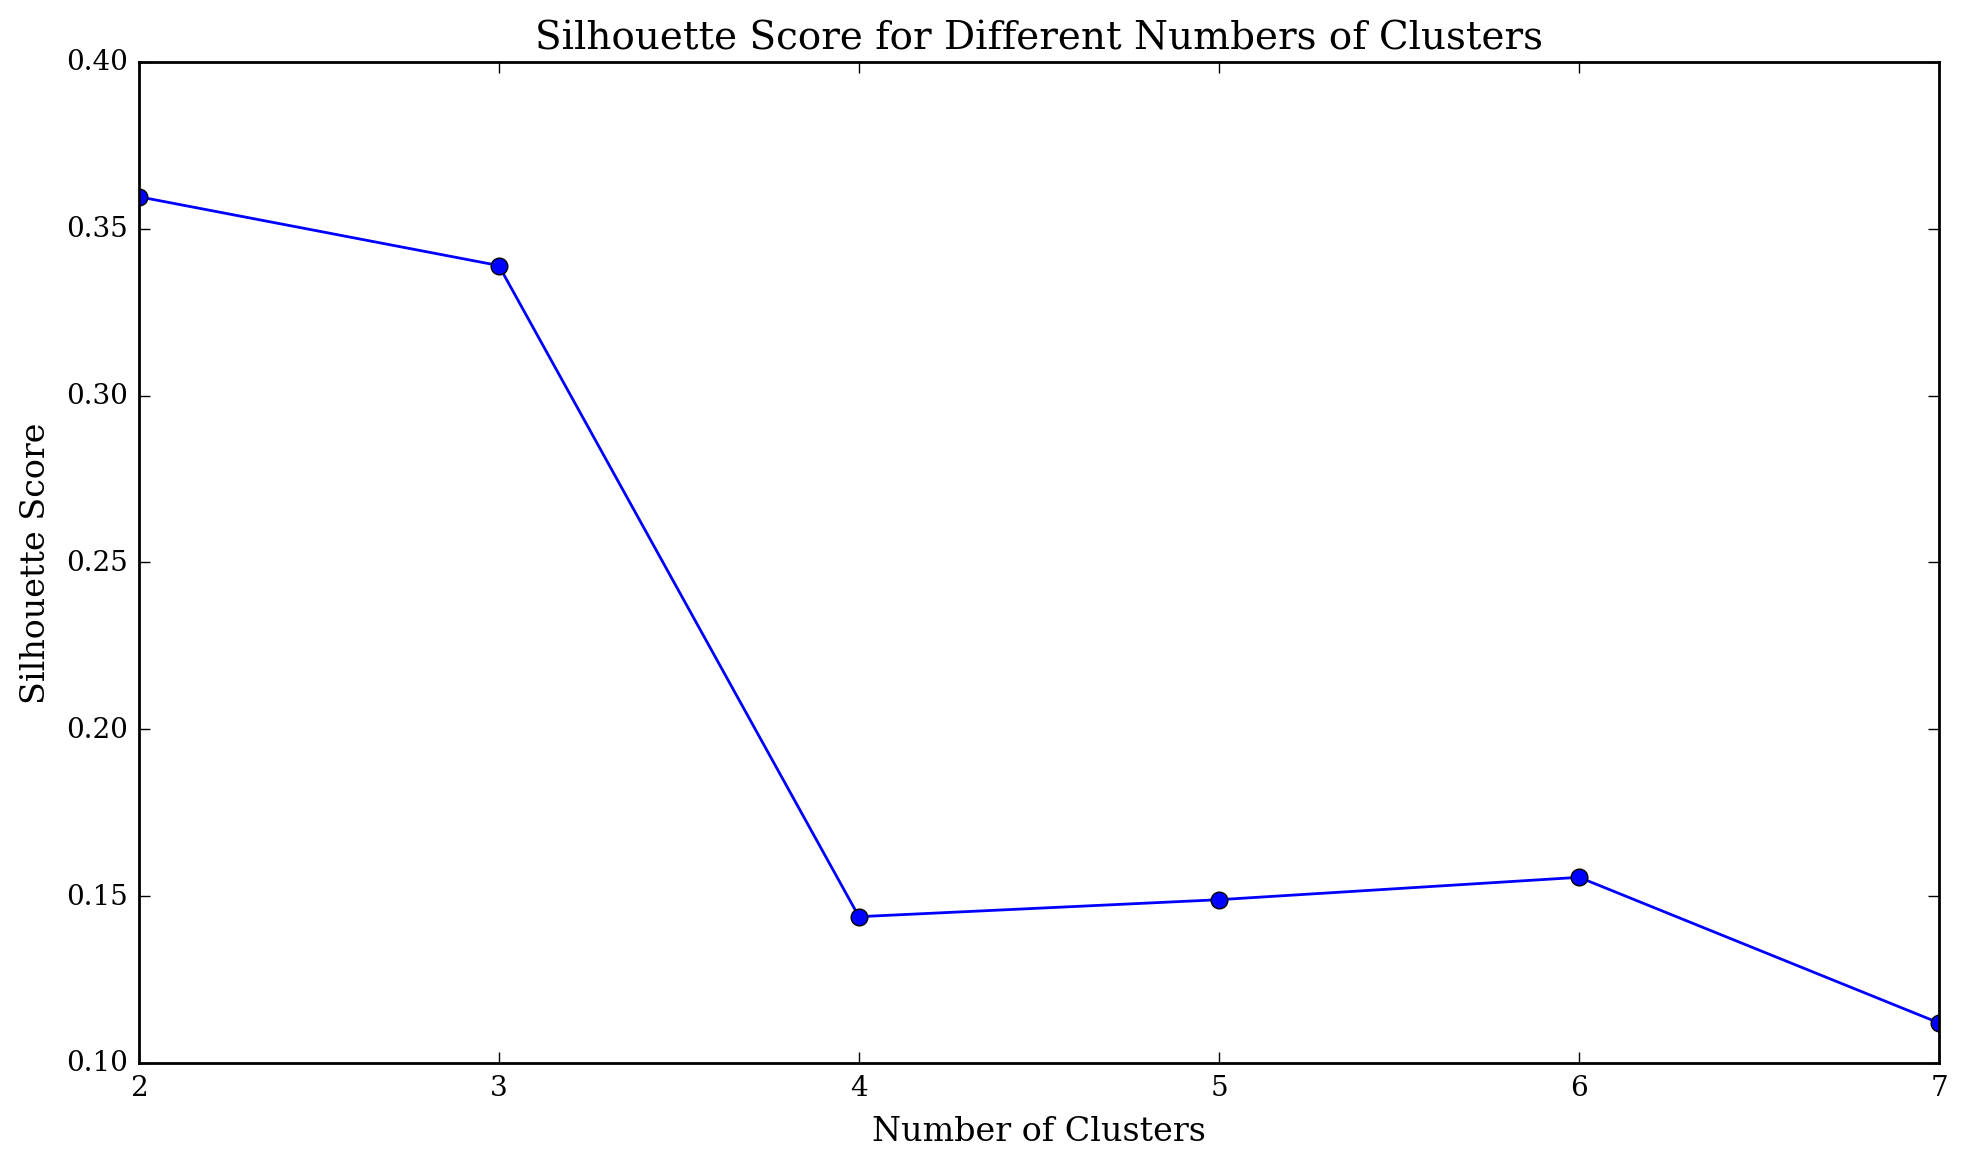

In [7]:
# Determine optimal clusters using silhouette score
silhouette_scores = []
range_n_clusters = list(range(2, 8))

for n_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot silhouette scores
plt.figure()
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.tight_layout()
plt.show()

4. **Cluster profiling**: Created visualisations showing cluster characteristics through:
* Bar charts displaying mean values and standard errors for key measures.
* Radar plots showing how different response systems interact within each cluster.

In [8]:
# Get optimal clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
cluster_labels = fcluster(Z, optimal_clusters, criterion='maxclust')
df_valid['cluster'] = cluster_labels

# Create scaled dataframe for visualization
scaled_df = pd.DataFrame(X_scaled, columns=features, index=df_valid.index)
scaled_df['cluster'] = cluster_labels
cluster_means = scaled_df.groupby('cluster')[features].mean()
cluster_stds = scaled_df.groupby('cluster')[features].std()

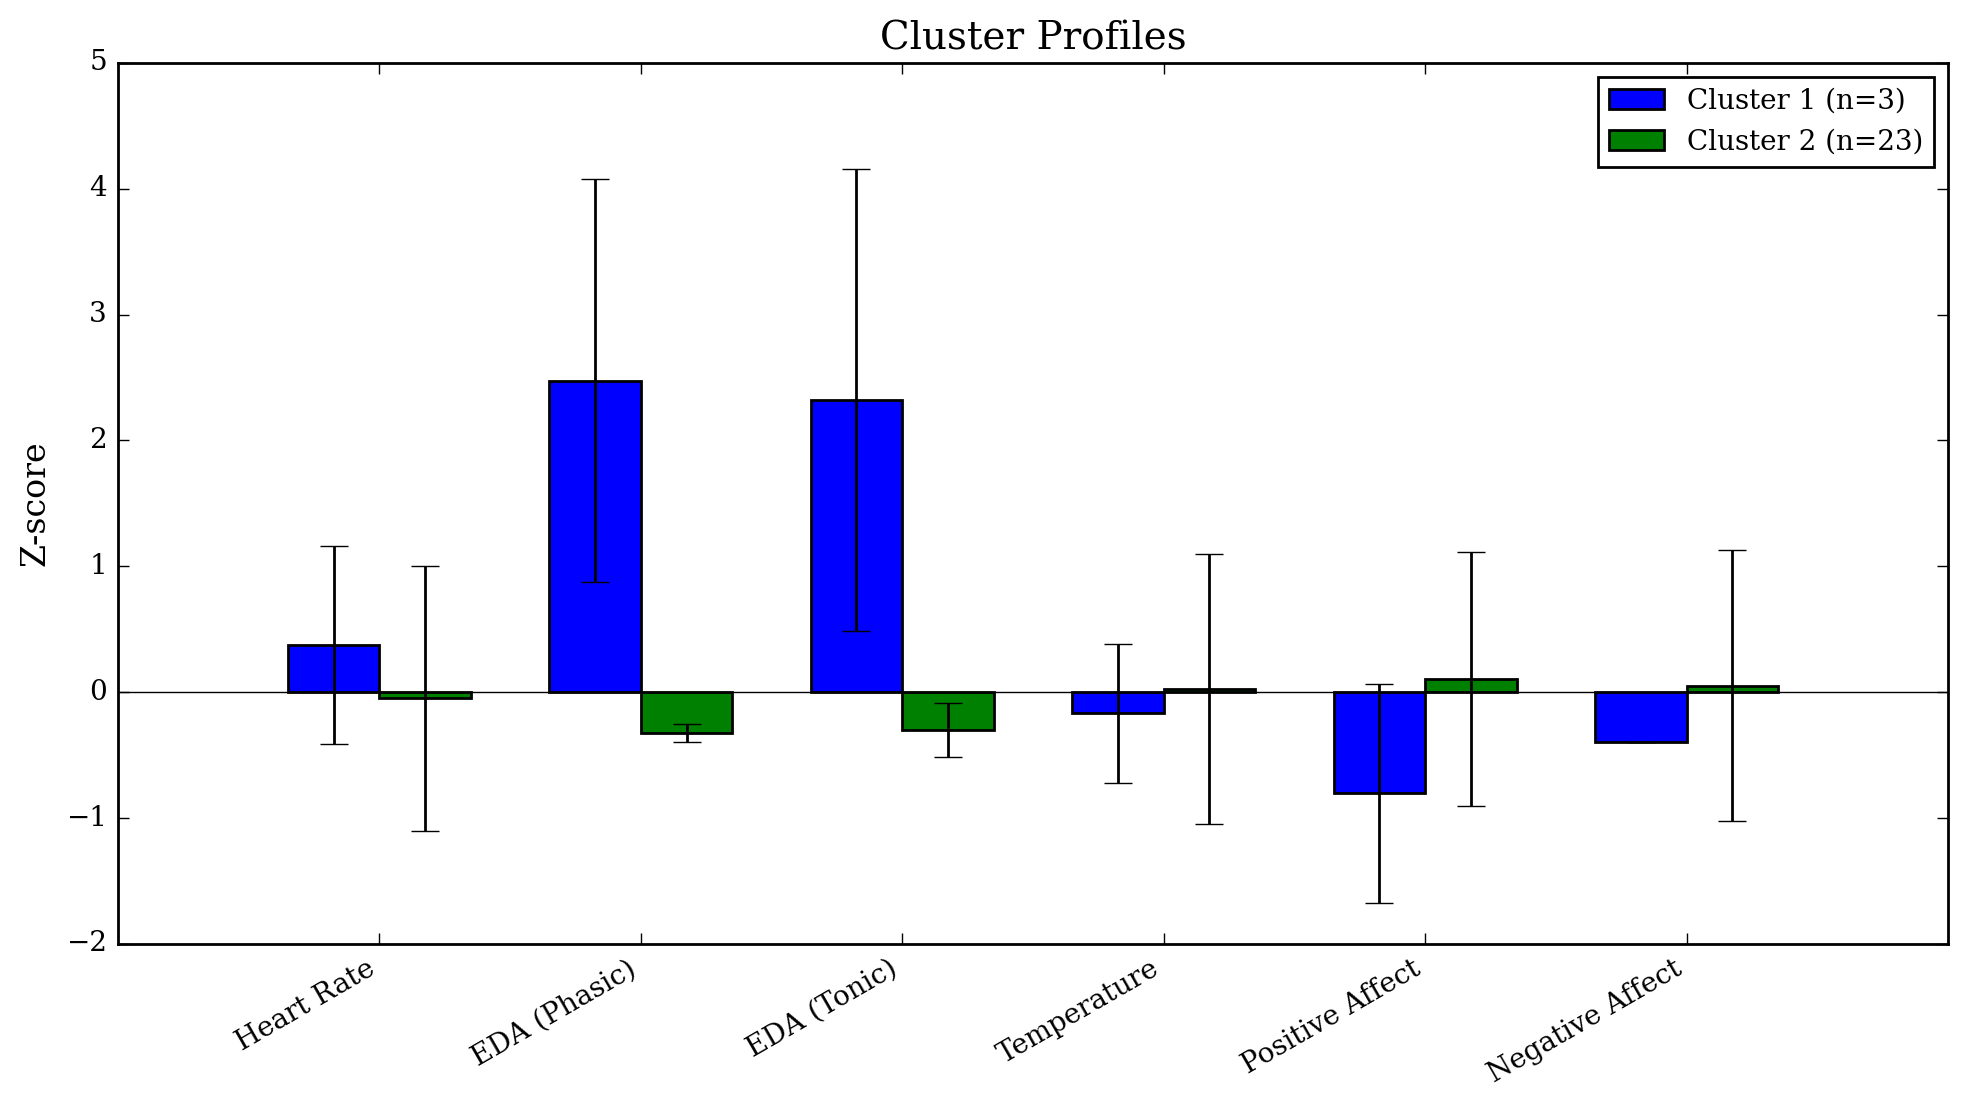

In [9]:
# Select key features for plotting
key_features = {
    'Heart Rate': 'z_d_P2R2_HR_TD_Median',
    'EDA (Phasic)': 'z_d_P2R2_EDA_TD_P_AUC',
    'EDA (Tonic)': 'z_d_P2R2_EDA_TD_T_AUC',
    'Temperature': 'z_d_P2R2_TEMP_TD_Mean',
    'Positive Affect': 'z_d_P2R2_PA',
    'Negative Affect': 'z_d_P2R2_NA'
}

# Plot bar chart
plt.figure()
bar_width = 0.35
index = np.arange(len(key_features))

cluster_counts = df_valid['cluster'].value_counts().sort_index()

for i, cluster in enumerate(sorted(cluster_means.index)):
    values = [cluster_means.loc[cluster, feat] for feat in key_features.values()]
    errors = [cluster_stds.loc[cluster, feat] for feat in key_features.values()]
    
    position = index + (i - 0.5*(len(cluster_means.index)-1)) * bar_width
    
    plt.bar(position, values, 
            width=bar_width, 
            yerr=errors, 
            capsize=5, 
            label=f'Cluster {cluster} (n={cluster_counts[cluster]})')

plt.xticks(index, key_features.keys(), rotation=30, ha='right')
plt.ylabel('Z-score')
plt.title('Cluster Profiles')
plt.legend()
plt.axhline(y=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

Results showed two distinct profiles:
* Cluster 1 (n=3): Strong physiological arousal with decreased positive affect, suggesting stress.
* Cluster 2 (n=23): Minimal physiological changes with slightly increased negative affect, indicating moderate response.